In [1]:
import sys
import warnings
import ee
warnings.filterwarnings('ignore')

In [3]:
!earthengine authenticate

Fetching credentials using gcloud
Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=qwEEkRNXLOBnx9VUKmrOVcEmJnnZ80&access_type=offline&code_challenge=UvDqYngdiLa5BgghmpDnYzjPMSS3IGrumHQPYIuBBpw&code_challenge_method=S256


Credentials saved to file: [/Users/victor/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update


Successfully saved authorization token.




# Loading packages



In [2]:
# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2

# Authenticate to Earth Engine
ee.Initialize(project="jpmorgancapstone")

# Fishnet

First, we can generate the fishnet using the following code. 

- We instantiate a `Fishnet` object 
- We generate the fishnet
- We aggregated the fishnet into batches corresponding to the images to extract froom the GoogleEarth Engine

In [5]:
# Create an instance of the Fishnet class
fishnet_creator_example = Fishnet('../Gis/Texas_State_Boundary/State.shp', 0.25, overlay_method='union', clip=False) 

# Create the fishnet
fishnet_creator_example.create_fishnet()

100%|██████████| 2948/2948 [01:17<00:00, 38.05it/s]


Generating polygons...
Success. Fishnet created.


id                                           geometry
0              0  POLYGON ((-106.64199 36.49677, -106.64199 36.5...
1              1  POLYGON ((-106.63775 36.49677, -106.63775 36.5...
2              2  POLYGON ((-106.63350 36.49677, -106.63350 36.5...
3              3  POLYGON ((-106.62926 36.49677, -106.62926 36.5...
4              4  POLYGON ((-106.62502 36.49677, -106.62502 36.5...
...          ...                                                ...
9132899  9132899  POLYGON ((-93.52168 25.83368, -93.52168 25.837...
9132900  9132900  POLYGON ((-93.51744 25.83368, -93.51744 25.837...
9132901  9132901  POLYGON ((-93.51319 25.83368, -93.51319 25.837...
9132902  9132902  POLYGON ((-93.50895 25.83368, -93.50895 25.837...
9132903  9132903  POLYGON ((-93.50471 25.83368, -93.50471 25.837...

[9132904 rows x 2 columns]

In [6]:
# creates batches of 4miles x 4miles
fishnet_creator_example.batch(4)  

100%|██████████| 185/185 [00:00<00:00, 422.92it/s]


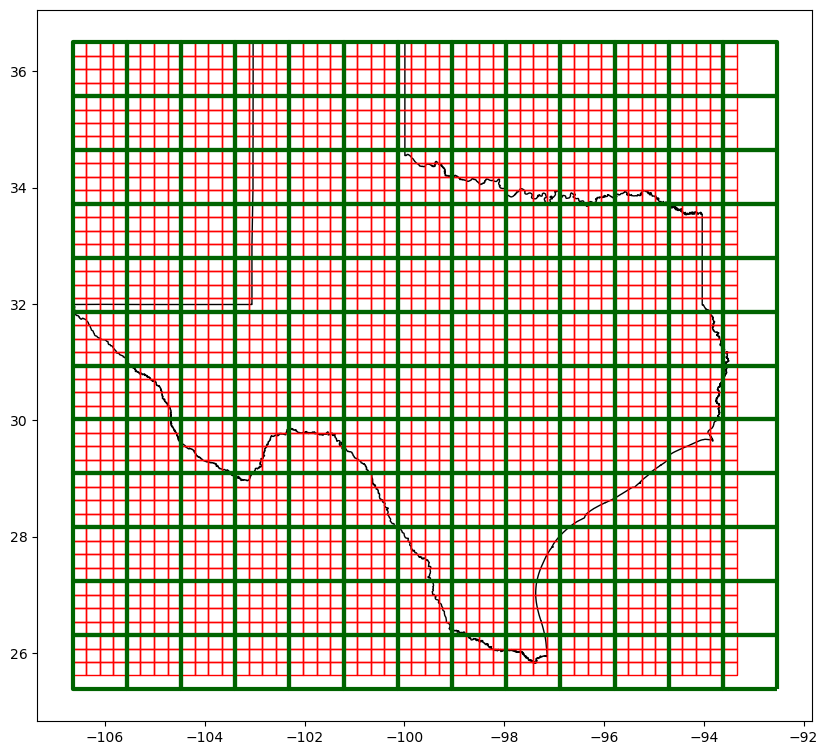

In [21]:
fishnet_creator_example.plot_fishnet()

## Filtering

We can filter the `Fishnet` to one specific region to avoid working on the whole area, simply to increase computational speed.

In [6]:
region = [-95.799944,29.374853,-95.028636,29.795492]

# Filter the fishnet by the larger bounding box
fishnet_creator_example.filter_fishnet_by_bbox(region)
fishnet_creator_example.filtered_fishnet.head(5)

id                                           geometry  batch_id
5743150  5743150  POLYGON ((-95.79960 29.79208, -95.79960 29.795...     22469
5743151  5743151  POLYGON ((-95.79536 29.79208, -95.79536 29.795...     22469
5743152  5743152  POLYGON ((-95.79111 29.79208, -95.79111 29.795...     22469
5743153  5743153  POLYGON ((-95.78687 29.79208, -95.78687 29.795...     22469
5743154  5743154  POLYGON ((-95.78263 29.79208, -95.78263 29.795...     22470

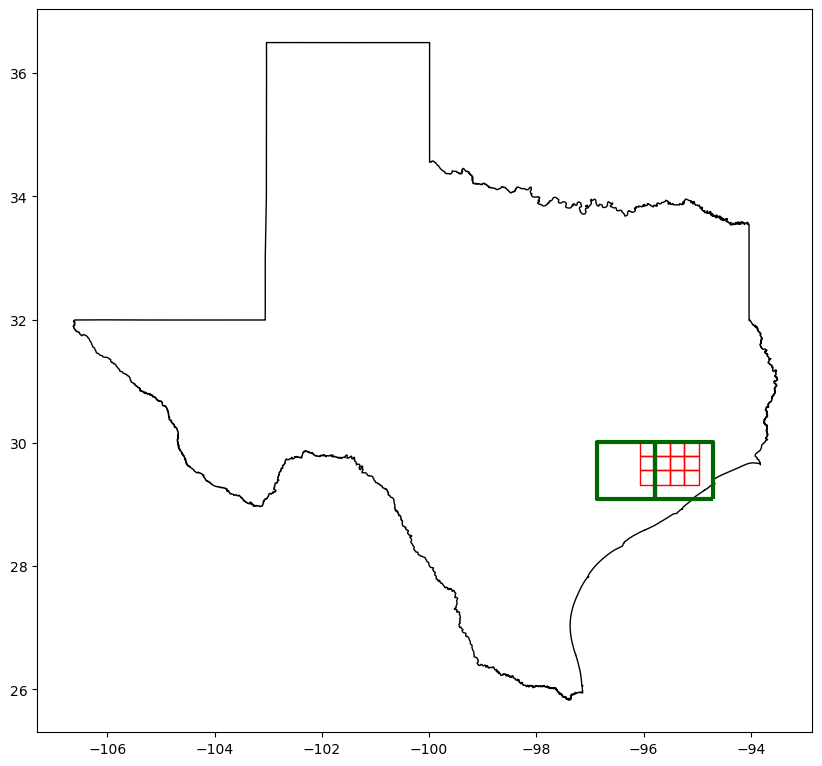

In [14]:
fishnet_creator_example.plot_filtered_fishnet()

## Save and load the fishnet object

In [7]:
# this specific fishnet was 0.25miles granular and 4miles edge of each batch.
fishnet_creator_example.save('../Gis/Fishnet/fishnet_quarter_mile.pkl') 

# load the object
fishnet_creator_example = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile.pkl')

# Export Images from the Google Earth Engine

In [6]:
# Load the granular fishnet (0.25miles x 0.25miles)
fishnet_creator = Fishnet.load("../Gis/Fishnet/fishnet_quarter_mile.pkl")

# Filter the fishnet (the one loaded is unfiltered)
region = [-95.799944,29.374853,-95.028636,29.795492]
fishnet_creator.filter_fishnet_by_bbox(region)

KeyboardInterrupt: 

In [25]:
fishnet_creator.compute_neighbors()

Computing neighbors...: 100%|██████████| 2948/2948 [00:23<00:00, 127.52it/s]


All neighbors computed successfully.


In [29]:
fishnet_creator.fishnet.head(5)

id                                           geometry  batch_id  \
0   0  POLYGON ((-106.64199 36.49677, -106.64199 36.5...         0   
1   1  POLYGON ((-106.63775 36.49677, -106.63775 36.5...         0   
2   2  POLYGON ((-106.63350 36.49677, -106.63350 36.5...         0   
3   3  POLYGON ((-106.62926 36.49677, -106.62926 36.5...         0   
4   4  POLYGON ((-106.62502 36.49677, -106.62502 36.5...         0   

                  neighbors  
0           [1, 3098, 3099]  
1  [0, 2, 3098, 3099, 3100]  
2  [1, 3, 3099, 3100, 3101]  
3  [2, 4, 3100, 3101, 3102]  
4  [3, 5, 3101, 3102, 3103]

In [30]:
fishnet_creator.filtered_fishnet.head(5)

id                                           geometry  batch_id  \
5743150  5743150  POLYGON ((-95.79960 29.79208, -95.79960 29.795...     22469   
5743151  5743151  POLYGON ((-95.79536 29.79208, -95.79536 29.795...     22469   
5743152  5743152  POLYGON ((-95.79111 29.79208, -95.79111 29.795...     22469   
5743153  5743153  POLYGON ((-95.78687 29.79208, -95.78687 29.795...     22469   
5743154  5743154  POLYGON ((-95.78263 29.79208, -95.78263 29.795...     22470   

                                                 neighbors  
5743150  [5740051, 5740052, 5740053, 5743149, 5743151, ...  
5743151  [5740052, 5740053, 5740054, 5743150, 5743152, ...  
5743152  [5740053, 5740054, 5740055, 5743151, 5743153, ...  
5743153  [5740054, 5740055, 5740056, 5743152, 5743154, ...  
5743154  [5740055, 5740056, 5740057, 5743153, 5743155, ...

In [31]:
fishnet_creator.plot_neighbor()

In [30]:
image_exporter = ImageExporter(fishnet_creator, filtered=True)

for year in [2017, 2018, 2019, 2020, 2021]:

    image_exporter.set_date_range(year)
    image_exporter.set_folder(f'DW_landcover_{year}')
    image_exporter.export_images()

100%|██████████| 117/117 [00:48<00:00,  2.43it/s]


# Correct Images

In [3]:
corrector = ImageCorrector('../Images/')

Loading images...:  75%|███████▌  | 6/8 [00:18<00:06,  3.11s/it]


FileNotFoundError: [Errno 2] No such file or directory: '../Images/CNN/Summer'

In [42]:
corrector.process_images()

Imputing Summer missing pixels with Year data. Processing images...
Processing images for year export_2022: 100%|██████████| 117/117 [00:01<00:00, 86.86it/s]


In [44]:
corrector.summary_final()

Loading images...: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
+-------------+--------------+---------------------+--------------------+
|     Year    | Final Images | Final Black Pixel % | Final Snow Pixel % |
+-------------+--------------+---------------------+--------------------+
| export_2016 |     117      |       0.0000%       |      0.0176%       |
| export_2017 |     117      |       0.0000%       |      0.0212%       |
| export_2018 |     117      |       0.0000%       |      0.0007%       |
| export_2019 |     117      |       0.0000%       |      0.0019%       |
| export_2020 |     117      |       0.0000%       |      0.0025%       |
| export_2021 |     117      |       0.0000%       |      0.0027%       |
| export_2022 |     117      |       0.0000%       |      0.0026%       |
+-------------+--------------+---------------------+--------------------+


# Process Images

In [1]:
# Process the images for 2016
img_process = ImageProcessor(
    fishnet_creator, "../Images/export_2016/", "landcover_batchID", "MeanPixel_2016", filtered=True
)
img_process.process_images()

NameError: name 'ImageProcessor' is not defined

In [12]:
# Process the images for 2022
img_process = ImageProcessor(
    fishnet_creator, "../Images/export_2022/", "landcover_batchID", "MeanPixel_2022", filtered=True
)
img_process.process_images()

Processing Images:: 100%|██████████| 117/117 [00:03<00:00, 30.83it/s]


In [13]:
# Save the new fishnet
fishnet_creator.save('../Gis/Fishnet/fishnet_quarter_mile_completed.pkl') 

# Load processed fishnet 

In [14]:
fishnet_creator = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile_completed.pkl')

In [15]:
fishnet_creator.compute_difference('MeanPixel_2022', 'MeanPixel_2016', filtered=True, normalize = True)
fishnet_creator.filtered_fishnet.head(5)

id                                           geometry  \
5743150  5743150.0  POLYGON ((-95.79960 29.79208, -95.79960 29.795...   
5743151  5743151.0  POLYGON ((-95.79536 29.79208, -95.79536 29.795...   
5743152  5743152.0  POLYGON ((-95.79111 29.79208, -95.79111 29.795...   
5743153  5743153.0  POLYGON ((-95.78687 29.79208, -95.78687 29.795...   
5743154  5743154.0  POLYGON ((-95.78263 29.79208, -95.78263 29.795...   

         batch_id      ImageCoordinates  MeanPixel_2016  MeanPixel_2022  \
5743150   22469.0  (567, 524, 615, 564)      162.960938      229.367188   
5743151   22469.0  (615, 524, 662, 564)       72.023936      245.912234   
5743152   22469.0  (662, 524, 709, 564)        0.271277      141.877660   
5743153   22469.0  (709, 524, 757, 564)       24.437500      230.031250   
5743154   22470.0     (0, 524, 47, 564)       88.300532      177.007979   

         MeanPixel_2022-MeanPixel_2016  
5743150                       0.260417  
5743151                       0.681915  
5743152                       0.555319  
5743153                       0.806250  
5743154                       0.347872

In [16]:
map_ = fishnet_creator.plot_heatmap(feature="MeanPixel_2022-MeanPixel_2016", filtered=True, zoom=True)

In [17]:
map_

In [102]:
map_.save("../Results/heat_map.html")